# POPPY Simulation: Magellan Telescope

In [25]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm 
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)

POPPY Version: 0.6.0rc1


## Initiate the optical elements and variables
- The values for the Magellan telescope pulled from Oli Durney's MagAO-X Zemax file.

### Current task:
- Implementing FITS file correctly for primary mirror surface

In [26]:
testWavelength = 656e-9 * u.m # H-alpha band for NSF MagAO-X
npix = 256  # resolution

# physical radius values
M1_radius = 3.239204 * u.m 
M2_radius = 0.632573 * u.m 
M3_radius = 0.439879 * u.m

# radius of curvature values
M1_roc = 16.26 * u.m
M2_roc = 2.862820 * u.m
fl_M1 = 8.128 * u.m
fl_M2 = M2_roc/2

# propagation distances from Zemax file
d_m1_m2 = 9.72205 * u.m
d_m2_m3 = 9.02279 * u.m
d_m3_f11fp = 4.979516 * u.m 

# intermediary distances
d_m1fp_m2 = d_m1_m2 - fl_M1
d_m2_f11fp = d_m2_m3 + d_m3_f11fp

M1 = poppy.QuadraticLens(fl_M1, name='M1')
M2 = poppy.QuadraticLens(fl_M2, name='M2')
# M3 is a flat mirror so nothing to declare here

## Begin Magellan Telescope build
<b>Note</b>: All Surface # counts are determined by Laird's MagAO-X spreadsheet design.

### Check Focal plane PSF of primary mirror

In [27]:
mag_tel = poppy.FresnelOpticalSystem(pupil_diameter=2*M1_radius, npix=npix*2, beam_ratio=0.34)

# Entrance Aperture
mag_tel.add_optic(poppy.CircularAperture(radius=M1_radius))
mag_tel.add_optic(poppy.SecondaryObscuration(secondary_radius=0.29*3.25, support_width=0.050, support_angle_offset=45.0))

### FITS PROBLEMS BEGIN HERE
#### Incorporating primary mirror surface using FITS file 

In [28]:
# open FITS file
m1_fits = fits.open('data/ClayM1_0mask_meters.fits')
m1_fits[0].header["PUPLSCAL"]=6.5/m1_fits[0].shape[0] # Add this value to header because current file doesn't exist with it

# Apply Workaround: change datatype for values in FITS file
m1_fits[0].data = np.float_(m1_fits[0].data)

# Build using FITSOpticalElement
M1_surf = poppy.FITSOpticalElement(opd=m1_fits, opdunits='meters')

# Surface -6: Primary Mirror (M1)
mag_tel.add_optic(M1_surf) # Should the surface be initiated before the mirror since the surface is seen first?
mag_tel.add_optic(M1)
mag_tel.add_optic(poppy.CircularAperture(radius=M1_radius,name="M1 aperture"))

In [29]:
m1_fits[0].header

SIMPLE  =                    T /Primary Header created by MWRFITS v1.8          
BITPIX  =                  -64                                                  
NAXIS   =                    2 /                                                
NAXIS1  =                  233 /                                                
NAXIS2  =                  233 /                                                
EXTEND  =                    T /Extensions may be present                       
PUPLSCAL=  0.02789699570815451                                                  

#### Observing the phase values from the primary mirror


/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
Optic(514, 514) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the rescaled array
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x

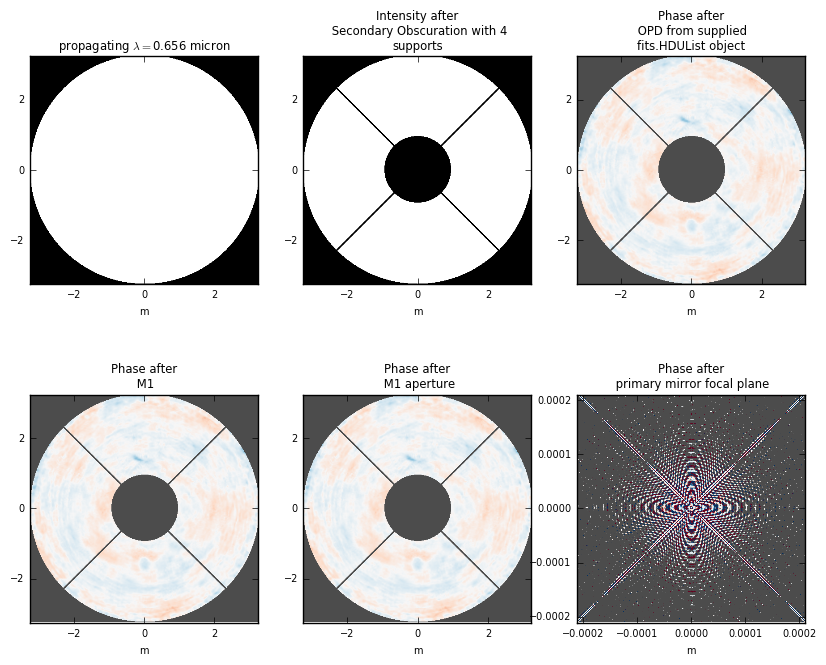

In [30]:
# Look at the focal point of primary mirror
mag_tel.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="primary mirror focal plane"), distance=fl_M1)

matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[10,8])
m1psf, m1_wfs = mag_tel.calcPSF(wavelength=testWavelength,
                                      display_intermediates=True,
                                      return_intermediates=True)

Additionally, the PSF at the M1 focal plane is non-existent:

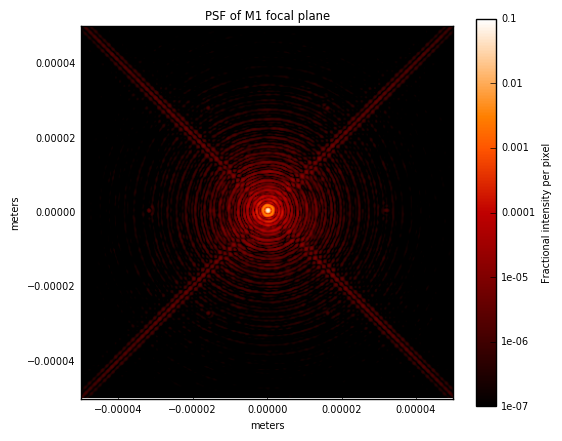

In [31]:
plt.figure(figsize=[6,5])
poppy.display_PSF(m1psf, imagecrop = 0.0001)
plt.title("PSF of M1 focal plane")
plt.xlabel("meters")
plt.ylabel("meters")

### Observe F/11 PSF from telescope
While I try to get the primary mirror FITS file to work correctly, the rest of this code will not be analyzed. It works if you don't add the primary mirror surface.

In [32]:
# Surface -5: Secondary Mirror (M2)
mag_tel.add_optic(M2, distance=d_m1fp_m2)
mag_tel.add_optic(poppy.CircularAperture(radius=M2_radius,name="M2 aperture"))

# Surface -4: Tertiary Mirror (M3, flat mirror)
mag_tel.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="M3 (flat)"), distance=d_m2_m3)
mag_tel.add_optic(poppy.CircularAperture(radius=M3_radius, name="M3 (flat) aperture"))

# Surface -3: F/11 Focal Plane
mag_tel.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/11 focal plane (unfixed)"), distance=d_m3_f11fp)

#### Comment on Focal Plane:
Zemax and POPPY have discrepancy for focal points. Zemax will find the optimal focus using real surfaces whereas POPPY calculates assuming paraxial rays and surfaces. Therefore, there needs to be a small correction installed to find the focal plane when using Zemax values.

In [33]:
# Focal plane correction for F/11
unfixed_f11fp_psf, unfixed_f11fp_wfs = mag_tel.calcPSF(wavelength=testWavelength, display_intermediates=False, return_intermediates=True)
f11_last_wave = unfixed_f11fp_wfs[-1]
f11_delta = f11_last_wave.z_w0 - f11_last_wave.z #f11_delta is the change in distance to compensate the gaussian beam waist.

# Incorporate the correction distance to see the F/11 PSF.
mag_tel.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/11 focal plane (corrected)"), distance=f11_delta)

/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
Optic(514, 514) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the rescaled array
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x

F/11 Focal Plane Correction Distance:

In [34]:
f11_delta

<Quantity 0.027078593987432953 m>

Show corrected distance affects the phase value:

/home/jhen/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
Optic(514, 514) is smaller than input wavefront[1536, 1536], will attempt to zero-pad the rescaled array
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2284: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_opd[border_x:border_x+resampled_opd.shape[0],border_y:border_y+resampled_opd.shape[1]] = resampled_opd
/home/jhen/anaconda3/lib/python3.5/site-packages/poppy-0.6.0rc1-py3.5.egg/poppy/poppy_core.py:2285: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self._resampled_amplitude[border_x:border_x

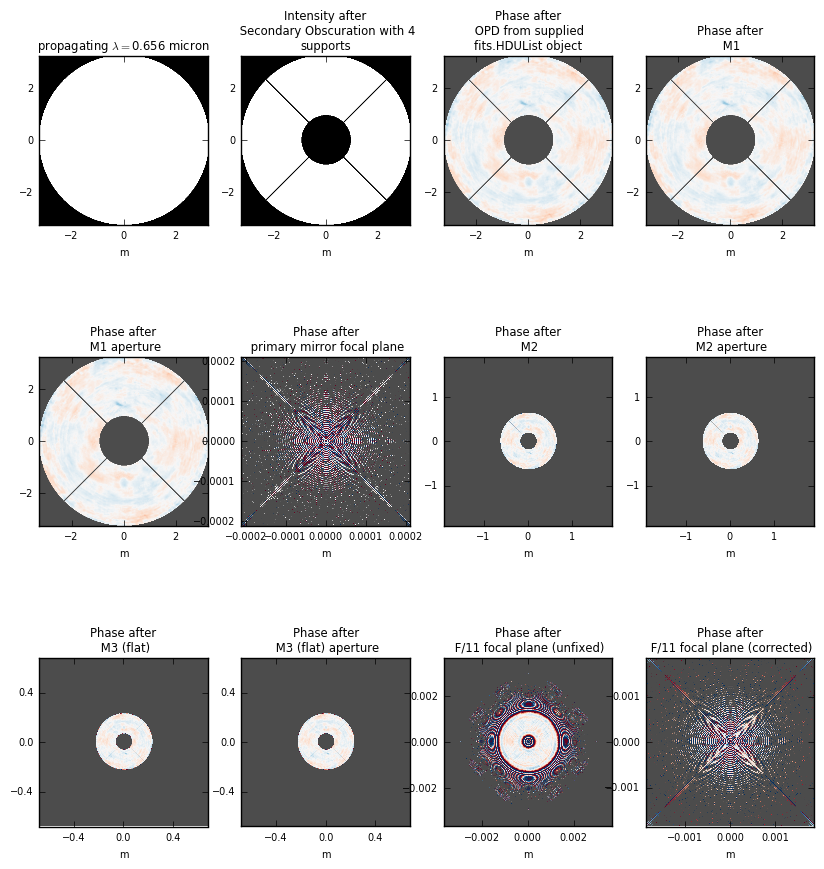

In [35]:
# Look at the corrected F/11 PSF
plt.figure(figsize=[10,11])
f11fp_psf, f11fp_wfs = mag_tel.calcPSF(wavelength=testWavelength,
                                      display_intermediates=True,
                                      return_intermediates=True)

### F/11 Telescope PSF

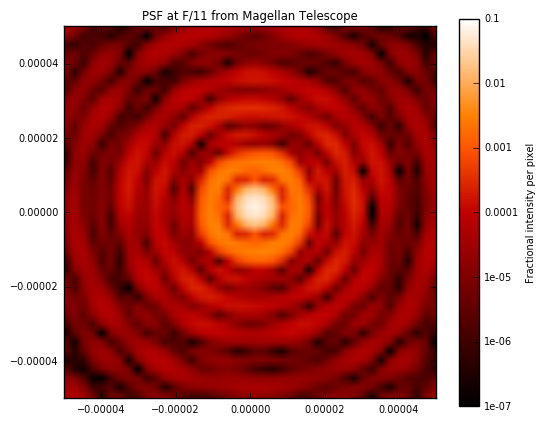

In [36]:
plt.figure(figsize=[6,5])
poppy.display_PSF(f11fp_psf, imagecrop=0.0001)
plt.title("PSF at F/11 from Magellan Telescope")